# Vowel Detection Neural Network

## Introduction
1. Train a Feedforward Neural Networks to recognize a vowel based on Linear Predictive Coding (LPC) Coefficients (`LPC14`)
2. Dataset Pairs `<LPC14 Coefficients of vowels, 1 Hot Encoding of Vowels>`
3. Change the number of hidden Layer Neural Network neurons to see which architecture best minimizes loss

### Vowel Classification
| Backness         | Vowel Transcription | [IPA](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/International_Phonetic_Alphabet&ved=2ahUKEwitgoiUvPWEAxUhGDQIHR2IDMoQFnoECBQQAQ&usg=AOvVaw3T7iQw-yz0dlfkE0oDRulL) | One Hot Encoding Index |
| ---------------- | ------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------- |
| Front            | iy                  | `i`                                                                                                                                                                                                                     | 1                      |
| Front            | ih                  | `ɪ`                                                                                                                                                                                                                     | 2                      |
| Front            | ey                  | `ɛ`                                                                                                                                                                                                                     | 3                      |
| Front            | eh                  | `æ`                                                                                                                                                                                                                     | 4                      |
| Front (diphtong) | ae                  | `ei`                                                                                                                                                                                                                    | 5                      |
| Back             | uw                  | `u`                                                                                                                                                                                                                     | 6                      |
| Central          | uh                  | `ə`                                                                                                                                                                                                                     | 7                      |
| Back             | ow                  | `o`                                                                                                                                                                                                                     | 8                      |
| Back             | ao                  | `ɔ`                                                                                                                                                                                                                     | 9                      |
| Back             | aa                  | `ɑ`                                                                                                                                                                                                                     | 10                     |

## Step 0) Import Libraries and Dataset Constants

In [9]:
# PyTorch for feedforward NN architecture library
import torch
import torch.optim as optim

# Science Python library for loading matlab `.mat` files containing training data `ground_truth.mat` and `training_lpc.mat` 
import scipy.io

# Plotting libraries for analyzing the loss and accuracy of the model
import matplotlib.pyplot as plt
import numpy as np

# For pathing
import os

In [8]:
# Training and Ground Truth Datset: Declared at the end of the Matlab file `Create_LPC_Data_Sets.m`
TRAINING_DATASET_PATH = "training_lpc1.mat"
TRAINING_DATASET_KEY = "training_lpc"

GROUND_TRUTH_DATASET_PATH = "ground_truth1.mat"
GROUND_TRUTH_DATASET_KEY = "ground_truth"

SAVE_DATA_PATH = "./training_losses/"

## Step 1) Import Training Data

In [13]:
# Load in Training Data from Matlab .mat file
training_data_with_meta_data = scipy.io.loadmat(TRAINING_DATASET_PATH)

In [14]:
# Note: `training_lpc` is a name we defined in Matlab
training_data = training_data_with_meta_data[TRAINING_DATASET_KEY]

In [15]:
# Load in Training Data from Matlab .mat file
ground_truth_with_meta_data = scipy.io.loadmat(GROUND_TRUTH_DATASET_PATH)

# Note: `training_lpc` is a name we defined in Matlab
ground_truth = ground_truth_with_meta_data[GROUND_TRUTH_DATASET_KEY]

In [101]:
# There are 218 training examples of LPC14
print(training_data.shape) 

(218, 14)


In [102]:
# There are 218 corresponding lables with a One Hot Encoding of length 10
print(ground_truth.shape) 

(218, 10)


## Step 2) Generate Model Architecture
- As we are trying to use different model architecture, we will use a function to encapsulate the model parameters

In [16]:
# Model Hyperparameters
LEARNING_RATE = 0.1
NUM_EPOCHS = 100000

# Model Architecture
INPUT_SIZE = training_data.shape[1]
OUTPUT_SIZE = ground_truth.shape[1]

### Step 2a) Create Vowel Classifier Architecutre
- Use a function to create the Feedforward NN architecture and its respective Stochastic Gradient Descent optimizer


Note: Model Has the following architecture:

| Layer # | Description                                          | Size                                                                   |
| ------- | ---------------------------------------------------- | ---------------------------------------------------------------------- |
| 1       | Input Neurons containing the LPC Values              | 14 (1 per LPC coefficient)                                             |
| 2       | Hidden Layer to convexify the classification problem | 1-5 (independent variable to see which architecture performs the best) |
| 3       | One Hot Encoding of the vowel                        | 10 (ten vowels)                                                        |

```
  Layer 1            Layer 2         Layer 3
    I1                                 
    I2                                 O1
    I3                                 O2
    I4                                 O3
    ...                X               ...
    I11                                O10
    I13
    I14  
```                               

In [6]:
def create_lpc_vowel_classifier(
    NUM_LPC: int,
    HIDDEN_LAYER_SIZE: int,
    ONE_HOT_ENCODING_SIZE: int,
    LEARNING_RATE: float
) -> tuple[torch.nn.Module, torch.optim.Optimizer]:
    """
    Creates a Feedforward Neural Network and an optimizer to improve the loss of the model.

    ## Parameters
    INPUT_SIZE: int
        Number of inputs to the NN (in our case, the number of LPCs)

    HIDDEN_LAYER_SIZE: int
        Number of inputs from Input to the Hidden Layer (variable for experimentation purposes)

    ONE_HOT_ENCODING_SIZE: int
        The final output layer's dimensions for the One Hot Encoding of the vowel

    LEARNING_RATE: float
        Learning Rate for the Stochastic Gradient Descent Optimizer    

    ## Returns
    model: torch.nn.Module
        feedforward NN with randomized weights and biases whose architecture is based on the function parameters
    optimzer: torch.optim.Optimizer
        Stochastic Gradient Descent object that uses the gradients calculated 
        by a `loss_function` to update the `model`'s weights and biases
    """

    # Step 1) Create the model architecture
    model = torch.nn.Sequential(
        # Layer 1
        torch.nn.Linear(NUM_LPC, HIDDEN_LAYER_SIZE),
        torch.nn.Sigmoid(),

        # Layer 2
        torch.nn.Linear(HIDDEN_LAYER_SIZE, ONE_HOT_ENCODING_SIZE),
        torch.nn.Softmax(dim=1)
    )

    # Step 2) Create the Stochastic Gradient Descent object
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    return model, optimizer

## Step 2B) Train Classifier
- Next we will have a function responsible for the training iterations of the `optimizer` and `model` we create from `create_lpc_vowel_classifier`

### Loss Function Type
- The `loss_function` sums the Mean Squared Error of `model prediction` vs `ground truth` 
- The loss is summed over all 218 samples of vowels using the `reduction=sum` flag

In [7]:
def train_model(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    training_data: torch.tensor,
    ground_truth: torch.tensor,
    NUM_EPOCHS: int,
    clock_rate: int,
    loss_function: torch.nn.modules.loss._Loss = torch.nn.MSELoss(reduction='sum'),
    print_loss_flag: bool = True
) -> list[float]:
    """
    Given a `model`, `optimizer`, and `training data`, this function trains the model using the `loss_function` which uses
    `Mean Squared Error` and `sum` by default.

    ## Parameters
    model: torch.nn.Module
        Neural Network Architecture used to train the model

    optimizer: torch.optim.Optimizer
        Training optimization type, default is Stochastic Gradient Descent for this project    
    
    training_data: torch.tensor
        Training data (X, NUM_LPC) matrix where X is the number of training samples.
    
    ground_truth: torch.tensor
        Ground truth data (X, 10) matrix where X is the number of training samples and 10 is the one hot encoding for each vowel
    
    NUM_EPOCHS: int
        Number of epochs to run training iterations for (note that the model may overfit for large numbers of epochs)
    
    clock_rate: int
        The returned list of losses adds the loss at every `clock_rate`th training iteration
    
    loss_function: torch.nn.modules.loss._Loss
        The loss function used to calculate the loss after testing all X training datasets

    print_loss_flag: bool
        Whether or not to print out the error at every `clock_rte`th training iteration to the console
    
    ## Returns
    loss_history: torch.nn.Module
        Records `NUM_EPOCHS//clock_rate` number evenly spaced losses across the training iterations
    """

    # Step 1) Convert the Training Data and Ground Truthof LPC values into a tensor
    training_tensor = torch.tensor(training_data, dtype=torch.float)
    ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.float)

    loss_history = []

    # Step 2) Train Model
    for i in range(NUM_EPOCHS):

        # Step 2a) Forward Propogate all samples of `training_data`
        vowel_prediction = model(training_tensor)

        # Step 2b) Calculate the loss
        loss = loss_function(vowel_prediction, ground_truth_tensor)

        # Step 2c) Calculate the new gradient (note: we need zero_grad() to clear the previous training iterations gradient)
        optimizer.zero_grad()
        loss.backward()

        # Step 2d) Apply the gradient with the learning rate to updated the weighs and biases
        optimizer.step()

        # Step 3) Record loss history

        if print_loss_flag and i % clock_rate == 0:
            loss_history.append(loss.item())
            print(loss.item())

    return loss_history

## Step 3) Analyze Data Visually
1. Use a plot for seeing the loss of the values over time
2. Visualize the prediction of the model using a 2D color plot
3. Overlay the loss values of different trials of training

In [150]:
def plot_all(
    loss_history: np.ndarray,
    num_trials: int,
    unit: int
) -> None:
    """
    Plots the loss of the first `num_trials` training sessions (A-E) of the Vowel Classifier for NN with 1 - 5 hidden neurons.

    Note: In this context, training session means an entire re-initialization of weights and biases of a fresh Neural Network
    
    ## Parameters
    loss_history: np.ndarray
        Shape: (Number of neurons in the hidden layer, number of training sessions, NUM_EPOCHS//CLOCK_RATE)
        A 3D numpy array where the x index is the number of hidden neurons and the y is the training session number, 
        and z is the recorded loss at every `CLOCK_RATE`th iteration.
    
    num_trials: int
        Plots the entire loss history for the first `num_trials` for each of the neural network architectures
    
    unit: int
        The number of training iterations that elapse between each Z index of loss_history(_, _, Z) 
        if unit = 1,000 iterations
        ex: loss_history(0, 0, 0) represents a neural network with 1 hidden neuron, during training session A, and the loss after the 0th epoch of training
            loss_history(0, 0, 1) represents the same neural network and training session as above and the loss after the `1,000`th epoch of training
    """

    plt.rcParams['figure.figsize'] = (15, 15)
    fig, axes = plt.subplots(nrows=5, ncols=5)
    plt.subplots_adjust(hspace=0.6, wspace=0.6)

    # The first axis in the 3D array is the number of hidden neurons used in the single vowel classification
    num_hidden_neuron_architectures = loss_history[0]

    for neuron_idx in range(num_hidden_neuron_architectures):
        for trial_idx in range(num_trials):
            # Title the graph: ex: Loss of 1 hidden Neurons for Trial A
            title = f"{neuron_idx + 1} Hidden, Trial {chr(ord('A') + trial_idx)}"

            # Format Titles
            cur_subplot = axes[neuron_idx][trial_idx]
            cur_subplot.set_title(title)
            cur_subplot.set_ylabel(f"Loss")
            cur_subplot.set_xlabel(f"1 unit = {unit} iterations")
            cur_subplot.yaxis.grid(True)

            # Format Boxplots for Front vs. Back Vowels
            cur_subplot.plot(loss_history[neuron_idx][trial_idx])

In [120]:
def save_data(
    to_save: list[float], 
    file_path: str, 
    file_name: str
) -> None:
    """
    to_save: list[float]
        The array of training losses to be written to a txt file
    
    file_path: str
        The destination of the file

    file_name: str
        The file name
    """

    # Step 1) Get the directory to create the file in
    directory = os.path.dirname(file_path)

    # Step 1b) if the file directory doesn't exist, make it
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Step 1c) create the full path to write to
    full_path = os.path.join(file_path, file_name)

    # Step 2) Write the entire training loss to that file
    with open(full_path, "w") as file:
        for loss in to_save:
            file.write(f"{loss}\n")

In [122]:
def calculate_cohens_d(dataset1: np.array, dataset2: np.array) -> tuple[np.float32, str]:
    """
    Compare the effect size of dataset1's and dataset2's LPC_X where
    X is an arbitrary LPC Coefficient

    ## Parameters
    lpc_x_dataset1 : np.array
        The Xth LPC coefficients for every sample in dataset 1
            ex: LPC 12 for all `front vowels`
    
    lpc_x_dataset2 : np.array
        The Xth LPC coefficients for every sample in dataset 2
            ex: LPC 12 for all `front vowels`
    
    Note: Both datasets should be have the same LPC index

    ## Returns
    cohens_d : np.float64
        Cohen's D or Effect Size of LPC Index X with respect to dataset 1 and dataset 2
            ex: How likely the difference between LPC X in dataset 1 and dataset 2 
                is to be noticeable in an experiment/real life scenario

    label: str
        Returns whether the effect size is Small, Medium, or Large
    """

    assert len(dataset1) > 1, "dataset1 must have more than 1 number" 
    assert len(dataset1) > 1, "dataset2 must have more than 1 number" 

    # Step 1) Numerator = Mean Difference
    mean_difference = np.mean(dataset1) - np.mean(dataset2)
    
    # Step 2) Get the total variance of both datasets
    total_variance = np.std(dataset1)**2 + np.std(dataset2)**2

    # Step 3) Normalize the Variance
    normalized_variance = np.sqrt(total_variance) / 2

    # Step 4) Calculate effect size
    cohens_d = mean_difference / normalized_variance

    # Step 5) Get the label according to Cohen's D
    label = ""
    if(abs(cohens_d) >= 0.8):
        label = "Large"
    elif(abs(cohens_d) >= 0.5):
        label = "Medium"
    else:
        label = "Small"
        
    return cohens_d, label

## Step 4) Linking It All Together

### Step 4A) Declare the constants of the models

In [11]:
# Number of hidden neurons
HIDDEN_LAYER_SIZES = [1, 2, 3, 4, 5]

# Number of trials for testing a single Hidden layer Architecture
NUM_TRIALS = 10

# Record every `Clock_Rate`th sample
CLOCK_RATE = 1000

### Step 4B) Declare the data structures which will hold the loss histories and calculate the loss

In [ ]:
# Let there be Five 2D planes where the rows represent the trial number and the columns represent the losses recorded
all_loss_histories = np.ndarray(
    (len(HIDDEN_LAYER_SIZES), NUM_TRIALS, NUM_EPOCHS//CLOCK_RATE),
)

# Use the sum of the Mean Squared Error loss of every sample in the dataset
loss_function = torch.nn.MSELoss(reduction='sum')

### Step 4C) Train each model architecture over `NUM_TRIALS` trials

In [ ]:
for num_hidden_neurons in HIDDEN_LAYER_SIZES:
    # Change the number of hidden neurons in the hidden layer
    
    for trial_num in range(NUM_TRIALS):
        # Step 1) Create Model
        model, optimizer = create_lpc_vowel_classifier(
            NUM_LPC=INPUT_SIZE,
            HIDDEN_LAYER_SIZE=num_hidden_neurons,
            ONE_HOT_ENCODING_SIZE=OUTPUT_SIZE,
            LEARNING_RATE=LEARNING_RATE
        )

        # Step 2) Train the model
        loss_history = train_model(
            model=model,
            optimizer=optimizer,
            training_data=training_data,
            ground_truth=ground_truth,
            NUM_EPOCHS=NUM_EPOCHS,
            loss_function=loss_function,
            clock_rate=CLOCK_RATE
        )
    
        # Step 3) Record Loss
        save_data(loss_history, SAVE_DATA_PATH, f"{num_hidden_neurons}_Hidden_Neurons_Trial_{chr(ord('A') + trial_num)}")
        all_loss_histories[num_hidden_neurons - 1][trial_num] = loss_history

## Step 5) Visualizing the Data
A) Plot Losses
B) Last Loss per architecture
C) Visualize Classification

### Step 5A) Plot Losses
- Plot the losses for 5 trials of each neural network architecture

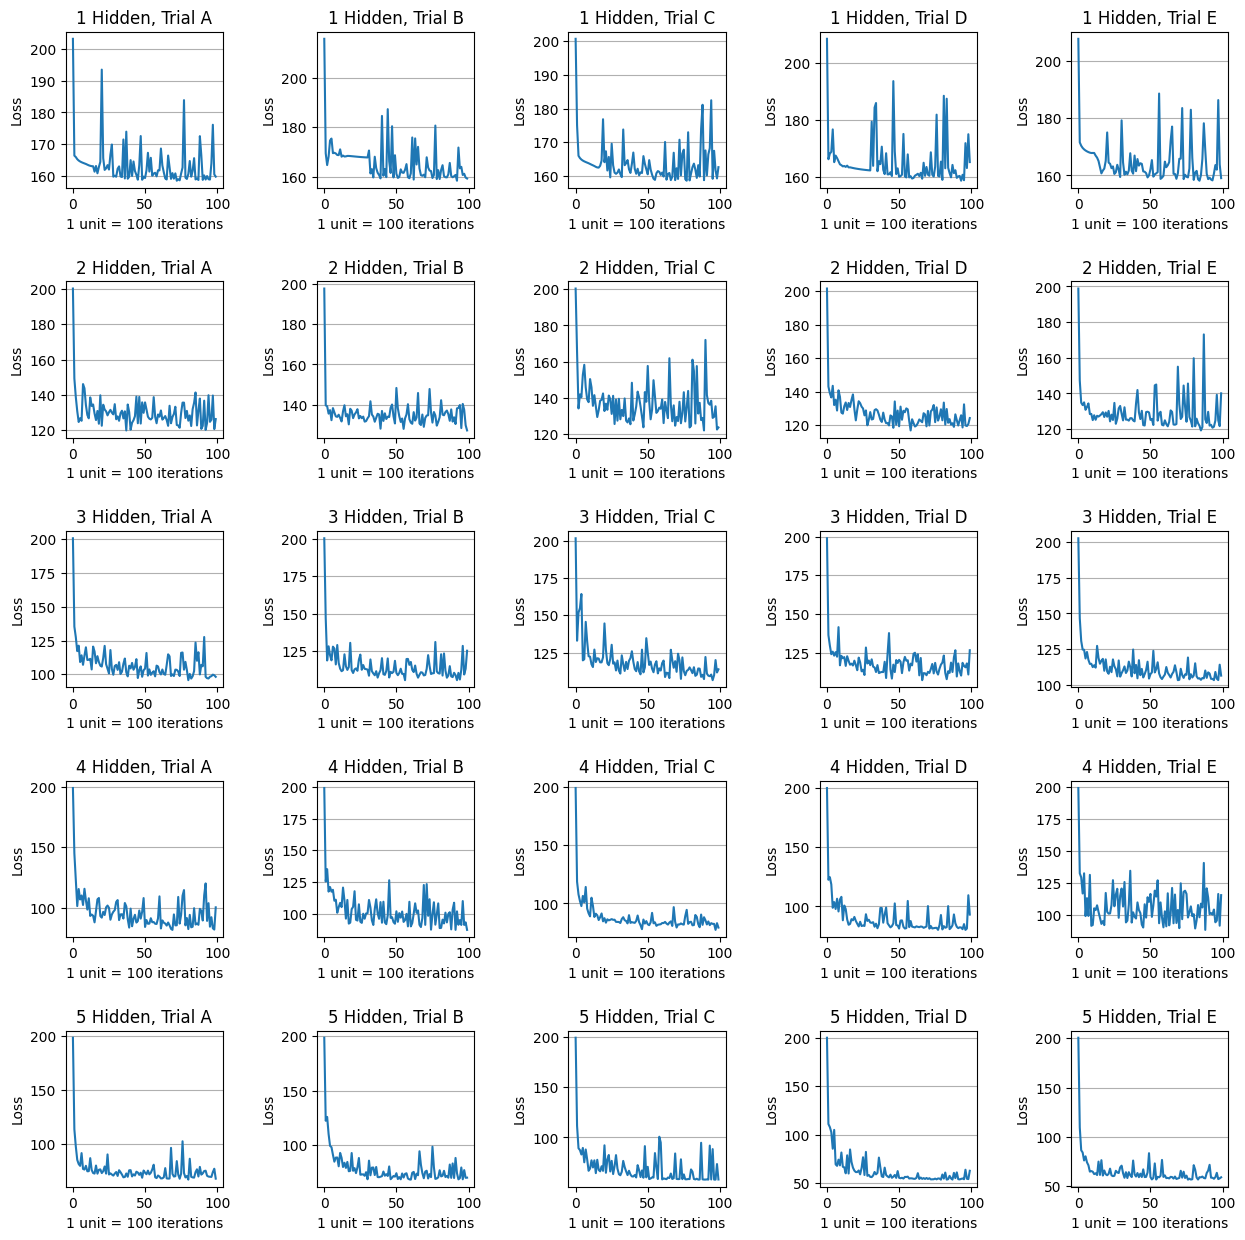

In [151]:
plot_all(loss_history=all_loss_histories, num_hidden_neurons=len(HIDDEN_LAYER_SIZES), num_trials=5, unit=NUM_EPOCHS//CLOCK_RATE)

### Step 5B) Last Loss per architecture
- Find how the median loss varies vs the number of neurons in the hidden layer

Median Losses: 162.95408630371094
Median Losses: 134.2169952392578
Median Losses: 109.7592544555664
Median Losses: 90.50627517700195
Median Losses: 76.25634384155273


Text(0.5, 0, 'Number of Hidden Neurons')

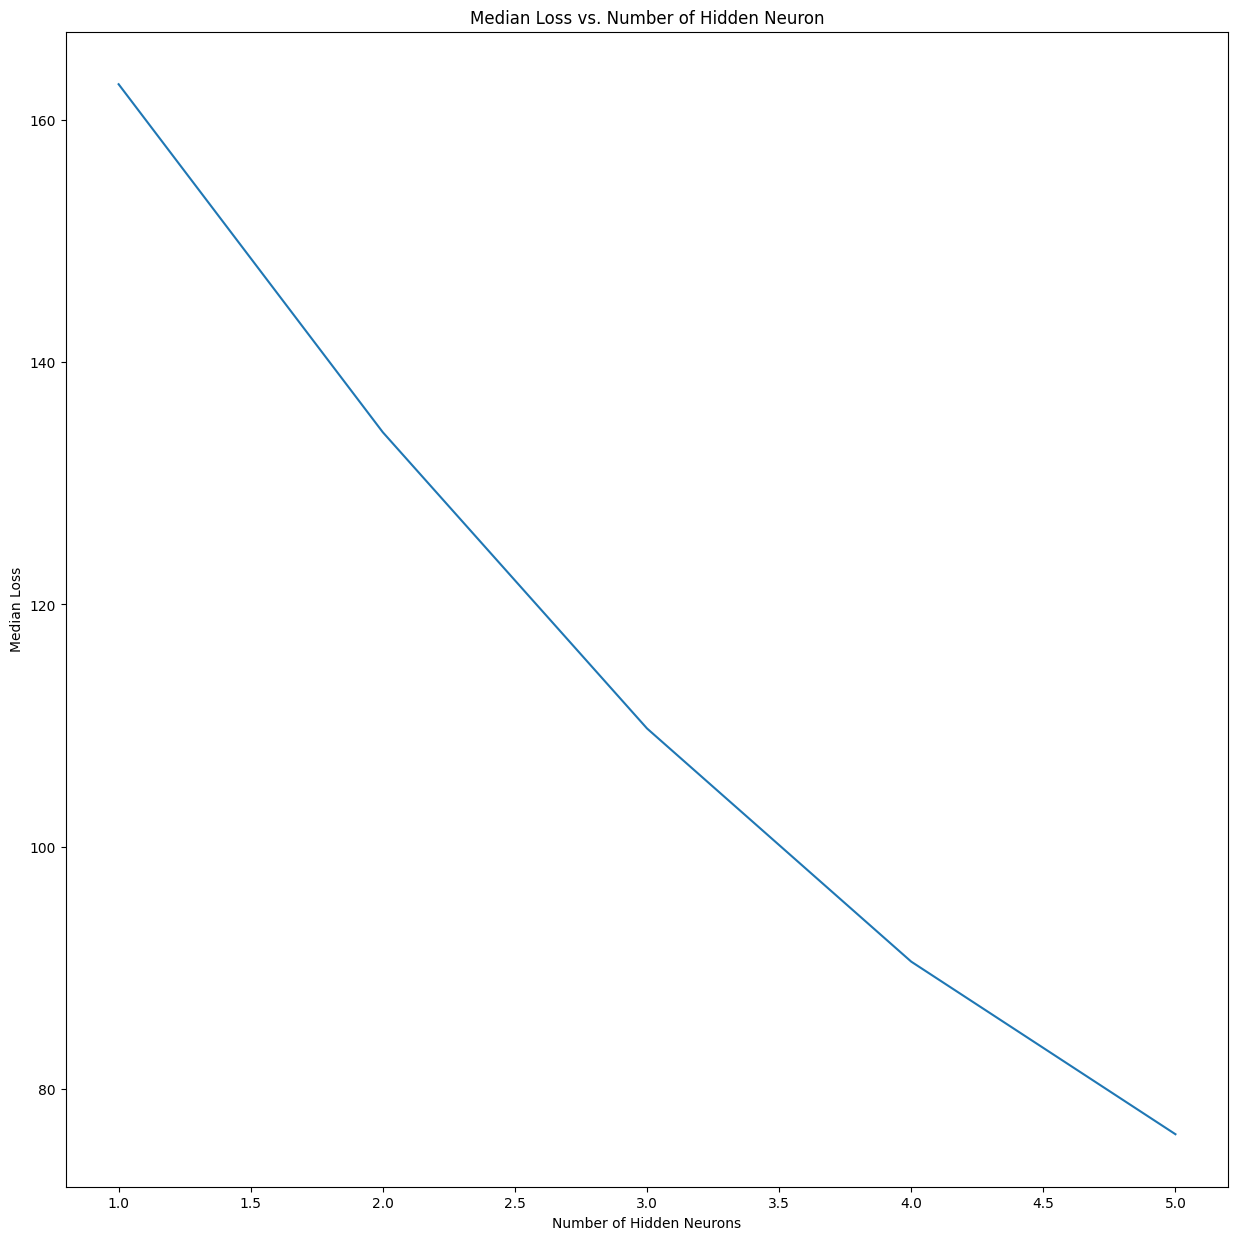

In [160]:
median_losses = []

for hidden_neuron_idx in range(len(HIDDEN_LAYER_SIZES)):
    # Step 1) Get the last loss for all iterations corresponding to `hidden_neuron_idx` 
    last_losses: np.array = all_loss_histories[hidden_neuron_idx][:][-1]

    # Step 2) Take the median of the last lost (approximate how well the model performed)
    last_loss_median = np.median(last_losses)

    # Step 3) Append to array
    median_losses.append(last_loss_median)

    print(f"Median Losses: {median_losses[-1]}")

plt.plot(HIDDEN_LAYER_SIZES, median_losses)
plt.title("Median Loss vs. Number of Hidden Neuron")
plt.ylabel("Median Loss")
plt.xlabel("Number of Hidden Neurons")

### Step 5C) Visualize Classification
- See how each of the 1 hidden neuron vs the 5 hidden neurons model classify the vowels

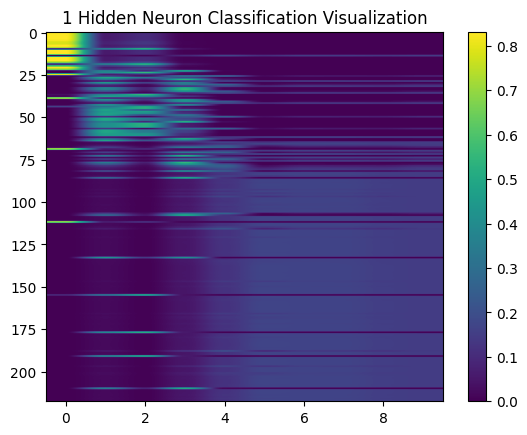

In [19]:
model, optimizer = create_lpc_vowel_classifier(
    NUM_LPC=INPUT_SIZE,
    HIDDEN_LAYER_SIZE=1,
    ONE_HOT_ENCODING_SIZE=OUTPUT_SIZE,
    LEARNING_RATE=LEARNING_RATE
)

# Step 2) Train the model
loss_history = train_model(
    model=model,
    optimizer=optimizer,
    training_data=training_data,
    ground_truth=ground_truth,
    NUM_EPOCHS=NUM_EPOCHS,
    clock_rate=CLOCK_RATE,
    print_loss_flag=False
)

prediction = model(torch.tensor(training_data, dtype=torch.float))
plt.imshow(prediction.detach().numpy(), aspect='auto')
plt.title(f"1 Hidden Neuron Classification Visualization")
plt.colorbar()

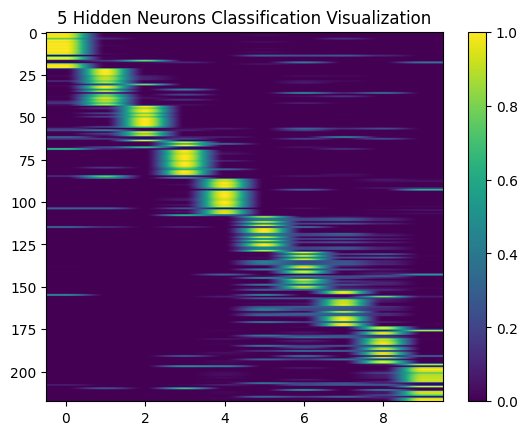

In [21]:
model, optimizer = create_lpc_vowel_classifier(
    NUM_LPC=INPUT_SIZE,
    HIDDEN_LAYER_SIZE=5,
    ONE_HOT_ENCODING_SIZE=OUTPUT_SIZE,
    LEARNING_RATE=LEARNING_RATE
)

# Step 2) Train the model
loss_history = train_model(
    model=model,
    optimizer=optimizer,
    training_data=training_data,
    ground_truth=ground_truth,
    NUM_EPOCHS=NUM_EPOCHS,
    clock_rate=CLOCK_RATE,
    print_loss_flag=False
)

prediction = model(torch.tensor(training_data, dtype=torch.float))
plt.imshow(prediction.detach().numpy(), aspect='auto')
plt.title(f"5 Hidden Neurons Classification Visualization")
plt.colorbar()